In [1]:
import numpy as np
import matplotlib
%matplotlib notebook
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time


#import autograd.numpy as npa
#from autograd import grad, value_and_grad

import legume
from legume import PlaneWaveExp, GuidedModeExp, Circle, ShapesLayer, Lattice, PhotCryst
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

In [2]:
def wg_sc(dx, dy, dr):
    """Define the photonic crystal waveguide given shift parameters
    dx, dy, and dr, for the 2*Nx*Ny_opt number of pillars that get shifted
    """
    phc = PhotCryst(lattice, eps_l = 1, eps_u = 1)
    
    # Initialize a layer and the positions of the pillars for the regular waveguide
    phc.add_layer(d=d, eps_b=eps_b)
    
    xc = []; yc = []
    for ih in range(Ny):
        if ih != Ny//2:
            for ix in range(-Nx//2+1, Nx//2+1):
                xc.append((ih%2)*0.5 + ix)
                if ih <= Ny//2:
                    yc.append((-Ny//2 + ih + (1-W)/2)*np.sqrt(3)/2)
                else:
                    yc.append((-Ny//2 + ih - (1-W)/2)*np.sqrt(3)/2)

    # Add all the pillars, taking care of the shifts
    for ih in range(1, Ny//2+1):
        nx1 = (Ny//2+ih-1)
        nx2 = (Ny//2-ih)
        if ih <= Ny_opt:
            # The ih row includes "optimization" pillars
            for ix in range(Nx):
                circ = Circle(x_cent=xc[nx1*Nx + ix] + dx[(ih-1)*Nx + ix],
                              y_cent=yc[nx1*Nx + ix] + dy[(ih-1)*Nx  + ix],
                              r = ra + dr[(ih-1)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
                circ = Circle(x_cent=xc[nx2*Nx + ix] + dx[(ih-1+Ny_opt)*Nx  + ix],
                              y_cent=yc[nx2*Nx + ix] + dy[(ih-1+Ny_opt)*Nx  + ix],
                              r = ra + dr[(ih-1+Ny_opt)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
        else:
            # The ih row includes just regular pillars
            for ix in range(Nx):
                circ = Circle(x_cent = xc[nx2*Nx + ix], y_cent=yc[nx2*Nx + ix], r=ra, eps=eps_c)
                phc.add_shape(circ)
                if ih < Ny//2:
                    circ = Circle(x_cent = xc[nx1*Nx + ix], y_cent=yc[nx1*Nx + ix], r=ra, eps=eps_c)
                    phc.add_shape(circ)

    # Construct and return a plane-wave expansion object
    return phc

In [3]:
# PhC parameters
a = 420
# ra = 0.5*256/a       # hole radius
eps_b = 3.453**2      # slab permittivity (n ~= 3.453 at low temp, n = 3.48 at room temp)
#eps_b = 11.7
eps_c = 1            # hole permittivity
d = 220/420          # slab thickness

# plane-wave expansion parameters
gmax = 2     # truncation of the plane-wave basis
Ny = 14      # Number of rows in the y-direction
Ny_opt = 3   # Number of rows in which the pillars will be modified
Nx = 1       # Supercell size in the x-direction

Ws = np.arange(0.8, 1.2, 0.01)
ra_actual = np.arange(240,280,1) # Hole Diameter in nm
ra_s = ra_actual*0.5/a # Legume Units

cross_wvlns = np.empty([len(Ws),len(ra_s)])

iteration = 0
total_it = len(Ws) * len(ra_s)

for i in np.arange(0,len(Ws)):
    for j in np.arange(0,len(ra_s)):
        W = Ws[i]
        ra = ra_s[j]

        # Initialize a rectangular lattice
        lattice = Lattice([Nx, 0], [0, (Ny+W-1)*np.sqrt(3)/2])

        # Initialize zero shifts
        dx0 = np.zeros((Nx*2*Ny_opt, ))
        dy0 = np.zeros((Nx*2*Ny_opt, ))
        dr0 = np.zeros((Nx*2*Ny_opt, ))

        # Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
        phc0 = wg_sc(dx0, dy0, dr0)

        nk = 30

        # Define a BZ path in kx
        path = phc0.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nk])
        #pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)

        neig = 30

        # Initialize GME
        gme = legume.GuidedModeExp(phc0, gmax=gmax)

        # Set some of the running options
        options = {'gmode_inds': [0], 
                   'numeig': neig,
                   'verbose': False
                    }

        # Run the simulation
        gme.run(kpoints=path['kpoints'], **options)

        f_ind = np.linspace(0, 1, neig)
        k = np.linspace(0, 0.5, nk+1)
        fv, kv = np.meshgrid(f_ind, k)
        # print(kv)
        n_eff = kv/gme.freqs
        wvln = a/gme.freqs

        ind = 14 # Index of mode in question

        n_target = 1.44
        n_diff = n_target - n_eff[:,ind]

        zero_crossings = np.where(np.diff(np.sign(n_diff)))
        cross_wvln = float(wvln[zero_crossings, ind])
        cross_wvlns[i,j] = cross_wvln
        
        iteration = iteration + 1
        
        print("Progress: " + str(iteration) + "/" + str(total_it) + "      ", end = "\r")
        

C:\Users\Toad\AppData\Local\Temp/ipykernel_16196/504418099.py:64: RuntimeWarning: invalid value encountered in true_divide
  n_eff = kv/gme.freqs
C:\Users\Toad\AppData\Local\Temp/ipykernel_16196/504418099.py:65: RuntimeWarning: divide by zero encountered in true_divide
  wvln = a/gme.freqs


In [4]:
# plt.plot(Ws, cross_wvlns)
# plt.xlabel("Waveguide Width (W)")
# plt.ylabel("Wavelength (nm)")

<IPython.core.display.Javascript object>


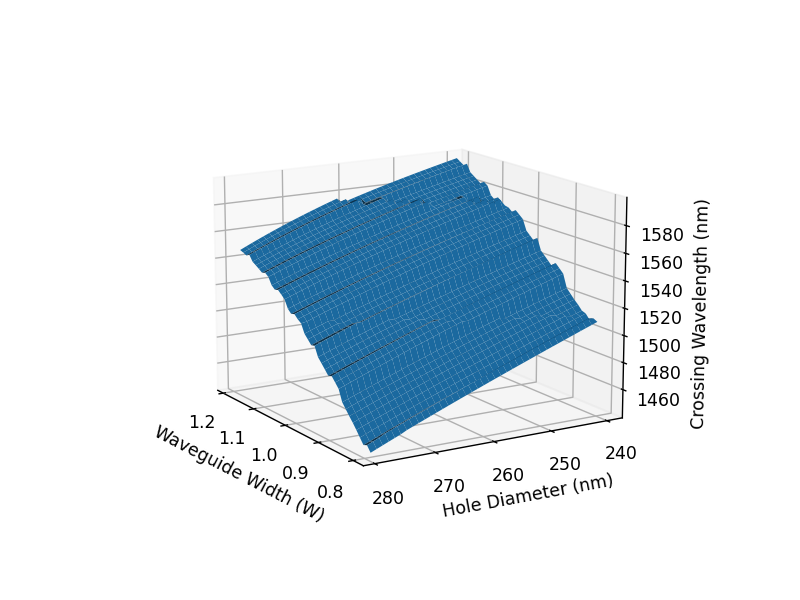

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

X, Y = np.meshgrid(Ws, ra_actual)

ax.plot_surface(X, Y, np.transpose(cross_wvlns))
ax.set_xlabel('Waveguide Width (W)')
ax.set_ylabel('Hole Diameter (nm)')
ax.set_zlabel('Crossing Wavelength (nm)');